# Fitting a statistical wind model 

## Background

During the last lecture, we discussed the impotance and challenges when fitting statistical models using extreme temperatures and river runoff extremes as case studies.

Another area, where statistical models are important is wind development. 

To assess a locations wind energy potential, we need to be able to model the overall distribution of wind speeds. 

Getting the wind speed distribution right, matters because wind power potential ($P$) is proportional to the third power of the wind speed ($v$). 

$P = 1/2 \rho A v^3$, 

with $\rho$ as air density, $A$ as rotor size of a wind turbine. 

The map below created by the [National Renewable Energy Laboratory](https://www.nrel.gov/) shows the estimated wind energy potential in the U.S.

![](https://www.nrel.gov/gis/assets/images/wtk-140m-2017-01.jpg)

##Learning Goals

- Practice fitting a statistical model the wind speed distribution
- Modularize code as functions for easier reuse
- Practice plotting and calculating statistics using `pandas` and `numpy`.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('ggplot')

## Task 1: Load and clean the wind data

The `data` folder contains two _*.csv_ files. One is from Phoenix uses in our last analysis (Station Code: USW00023183), the other one is taken from Charlottesville Airport. You can use either file. 

### Subtasks 1.1: Load the wind data into a dataframe
Subtasks

- Load the NOAA station data into a dataframe
- Save the the average wind speed `AWND` to a new dataframe.
  
  _Hint: `['<varname>']` will produce a pandas Series, while `[['<varname>>']]` will produce a pandas DataFrame_  
- Inspect the contents of the dataframe

In [2]:
 weather_phoenix = pd.read_csv('../data/NOAA_GHCN_USW00023183.csv',
                             parse_dates=['DATE'],
                             index_col = ['DATE'])
weather_phoenix.head()

/var/folders/2k/gvq989955h5c83f9wmz5fj_80000gn/T/ipykernel_57297/2170646884.py:1: DtypeWarning: Columns (16,22,26,28,32,34,38,40,44,46) have mixed types. Specify dtype option on import or set low_memory=False.
  weather_phoenix = pd.read_csv('../data/NOAA_GHCN_USW00023183.csv',


,STATION,NAME,AWND,AWND_ATTRIBUTES,FMTM,FMTM_ATTRIBUTES,PGTM,PGTM_ATTRIBUTES,PRCP,PRCP_ATTRIBUTES,...,WSF2,WSF2_ATTRIBUTES,WSF5,WSF5_ATTRIBUTES,WSFG,WSFG_ATTRIBUTES,WSFI,WSFI_ATTRIBUTES,WSFM,WSFM_ATTRIBUTES
DATE,,,,,,,,,,,,,,,,,,,,,
1934-01-01,USW00023183,"PHOENIX AIRPORT, AZ US",NaN,NaN,NaN,NaN,NaN,NaN,0.0,"P,,6,null",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1934-01-02,USW00023183,"PHOENIX AIRPORT, AZ US",NaN,NaN,NaN,NaN,NaN,NaN,0.0,"P,,6,null",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1934-01-03,USW00023183,"PHOENIX AIRPORT, AZ US",NaN,NaN,NaN,NaN,NaN,NaN,0.0,"P,,6,null",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1934-01-04,USW00023183,"PHOENIX AIRPORT, AZ US",NaN,NaN,NaN,NaN,NaN,NaN,0.0,"P,,6,null",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1934-01-05,USW00023183,"PHOENIX AIRPORT, AZ US",NaN,NaN,NaN,NaN,NaN,NaN,0.0,"P,,6,null",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
weather_phoenix [['AWND']]
wind_speed = weather_phoenix [['AWND']]

### Subtasks 1.2: Remove missing values 

You can use the `.dropna()` method to remove rows with _nan_-values

In [4]:
wind_speed = wind_speed.dropna()
wind_speed

,AWND
DATE,
1984-01-01,4.70
1984-01-02,12.08
1984-01-03,6.93
1984-01-04,7.38
1984-01-05,5.82
...,...
2024-03-23,9.40
2024-03-24,12.97
2024-03-25,8.50


## Task 2: Explore the data

### Subtask 2.1: Look at basic wind statistics

_Hint: `.describe()`

In [5]:
 wind_speed.describe()

,AWND
count,14692.000000
mean,6.154301
std,2.221693
min,0.450000
25%,4.700000
50%,5.820000
75%,7.610000
max,20.130000


### Subtask 2.2: Plot the wind data as a histogram

Use a sufficent number of bins `bins=` so that you can see the underlying distribution. 

Set `density = True` to get the probability distribution rather than raw counts.

<Axes: ylabel='Frequency'>

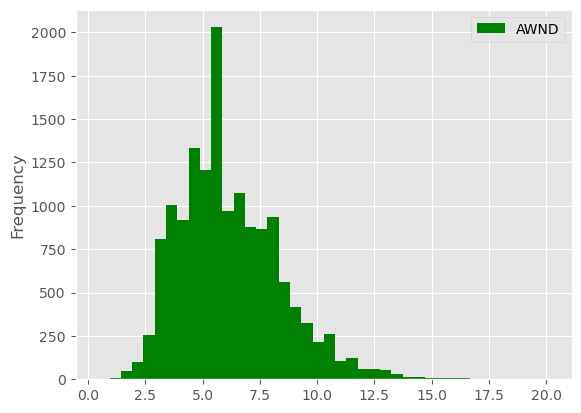

In [6]:
wind_speed.plot(kind= 'hist', bins= 40, color= "green")

## Taks 3: Fit a Weibull distribution to the wind data 

We want to fit a statistical model to the data. 

To do so, we need to: 

1. Decide on an appropriate statistical model
2. Estimate the model's parameter
3. Validate the model against our observations to ensure that it is appropriate

### Task 3.1: Decide on a model 

The Weibull distribution is one of [many different assumed wind speed distributions](https://www.frontiersin.org/articles/10.3389/fenrg.2021.769920/full) used in wind energy assessment. 

The Weibull distribution is a two parametric function expressed mathematically as (Perez et al, [2007](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2006JD008278)):

![](https://agupubs.onlinelibrary.wiley.com/cms/asset/5632b77b-0544-4101-ad3b-e5dd9610865c/jgrd13704-math-0001.gif)

where $v$ is the wind speed, $c$ is the scale factor, and $k$ is the dimensionless shape parameter. 

Here are examples of the Weibull probability function for different parameter choices:

![](https://upload.wikimedia.org/wikipedia/commons/thumb/5/58/Weibull_PDF.svg/488px-Weibull_PDF.svg.png)

_Source: [Wikipedia - Weibull Distribution](https://en.wikipedia.org/wiki/Weibull_distribution)_

### Aside: Functions in Python

In python, we can define [functions](https://www.w3schools.com/python/python_functions.asp) like the ones below that takes two variables as arguments and will return their sum. 

In [7]:
def aPowerB(a,b):
    result = a**b
    return result

def exponentialExample(a,b):
    result = np.exp(a+b)
    return result

After the function is defined, we can use it like this:

In [8]:
x1=2
x2=3
print('a^b =', aPowerB(x1,x2))
print('e^(a=b)= ', exponentialExample(x1,x2))

a^b = 8
e^(a=b)=  148.4131591025766


### Task 3.1.1: Code up the Weibull function

Functions help us modularize our code. We can reuse them over and over without having to retype the operations. 

Let's now code up the Weibull PDF as a python function. You can use the code stub below.  

In [21]:
def weibullPDF(x,k,c):

    f = (k/c)*((x/c)**(k-1))*np.exp(-(x/c)**k)
    
    return f

### Testing the Weibull function

Let's try to reproduce the figure above using our newly coded function.

If you did it correctly, the figures should look similar. If not check your code... 

/var/folders/2k/gvq989955h5c83f9wmz5fj_80000gn/T/ipykernel_57297/144253833.py:3: RuntimeWarning: divide by zero encountered in power
  f = (k/c)*((x/c)**(k-1))*np.exp(-(x/c)**k)


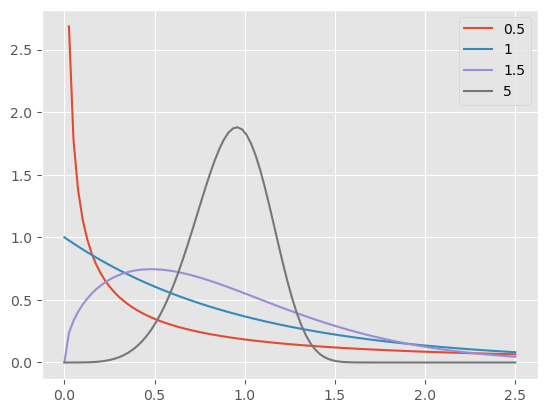

In [22]:
fig = plt.figure() 

klist = [0.5, 1, 1.5, 5]
x = np.linspace(0,2.5,100) # This creates 100 x values between 0 and 2.5
for k in klist: 
    pdf = weibullPDF(x,k,1)
    plt.plot(x,pdf, label = k)
    plt.legend()

### Task 3.2: Model Parameter Estimation

Next, we need to find the parameters that provide the best fit of the Weibull distribution to our wind data.

One way of doing so, is to use an optimization algorithm that compares the observed distribution to the theoretical distrubtion. 

Such algorithms seek to minimize a `penalty function`. 

**The smaller the penalty value, the better the fit!**



### 3.2.1 Decide on success criterion

A commonly used penality function is the Sum of Squares.  

$SoS = \Sigma_i[(y_i - y_{est,i})^2]$

Let's code it up below: 

_Hint: You can use `np.sum()`._ 

_Running the cell will show you, whether you did it right_

In [ ]:
def penaltyFunction(y,y_est):
    penalty =   np.sum(
    return penalty


# don't change the lines below
y1 = np.array([1,1,3])
y2 = np.array([1,1,1])
SoS = penaltyFunction(y1,y2)
print('Correct SoS = ', 4, 'Your SoS: ', SoS)

### Task 3.2.2 Getting observed wind speed probabilities

We can use the `np.histogram()` function (which is actually the function used by the pandas histogram, to calculate the observed wind speed probabilities. 

To do so, use the same numer of bins in the original plot 

In [ ]:
# The below code if done correct, will save the probabilities to the probability variable, and also return the edges for each bin
observedPDF, binEdges= np.histogram()

# The wind speeds are the center of each bin, calculated as (don't change this)
windSpeedClass=(binEdges[:-1]+binEdges[1:])/2

### Task 3.2.3: Putting it all together

We can now put everything together to estimate our parameters. 

The code below uses two loops to loop over different values for `k` and `c`. 

Then the code should do the following:

1. Calculate the Weibull PDF for the value of `k` and `c` at the wind speed classes from the histogram.
2. Calculate the penalty function between the Weibull PDF and the Observed PDF.
3. Compare the Penalty Function to the current minimum value of the Penalty function
4. If the current Penalty Function is smaller than the current minimum. Update the optimal parameters for
   - k
   - c
   - minimum Penalty function.

In [ ]:
import time

n=100
ks = np.linspace(0,10,n) # defines the values of k to test
print(ks)
cs = np.linspace(0,10,n) # defines the values of c to test

# Setting intial values, leave unchanged
kOpt = []
cOpt = []
PenaltyOpt = np.inf

t1= time.perf_counter()
# This code loops over all the k and c values defined above:
for k in ks:
    for c in cs:
        ## Complete the code below to evaluate the weibullPDF for the k and c value (1 line)
        modeledPDF = # 
        ## 

        ## omplete the code below to calculate the sum of squares beteen the modeledPDF and observedPDF (1 line)
        Penalty = 
        ## 

        # Compare the Penalty to Optimal Penalty found so far
        # If the current penalty is smaller than the optimal Penalty, update kOpt, lOpt, PenaltyOpt to new values
        # Update the 4 lines below
        if ():
            kOpt = #
            cOpt = #
            PenaltyOpt = #
        # 

t2 = time.perf_counter()
duration = t2-t1

print(f'The code took {duration:.2f} seconds to run')
print('fitted k: ', kOpt, 'fitted l: ', cOpt, 'RMSE: ', PenaltyOpt) 


### Evaluationg the model

We can now investigate how well our model does by plotting things together. 

In [ ]:
plt.figure()
ax = wind_speed['AWND'].hist(bins = 30, density = True)
plt.plot(windSpeedClass,weibullPDF(windSpeedClass,kOpt,cOpt))
plt.text(15,0.2,f'SOS ={PenaltyOpt:.3f}',fontsize = 12)
plt.text(15,0.18,f'k = {kOpt:.3f}',fontsize = 12)
plt.text(15,0.16,f'l = {cOpt:.3f}',fontsize=12)

## Task 4: Evaluate Model Performance

Change the value of the `n` parameter in the parameter fitting alogrithm. 

See what happens to the optimal parameters and the time it takes to run. 


**P.S.: Looping over all values is very inefficient. Numerical solvers, like `scipy.optimize()` will use different techniques. A common optimization algorithm used is [Gradient Descent](https://en.wikipedia.org/wiki/Gradient_descent), which avoids having to test all values.** 

## Super Task 5: Turn the optimization into a function

You could turn the entire optimization loops above into a function and then use this function to investigate how the runtime and the optimized parameters change for different values of `n`. 

In [ ]:
# Here is a bit of code, that could help you when running your 
ns = np.logspace(1,5,10)
print(ns)

runtimes = []
cOpts = []
kOpts = []

for n in ns:
    
    cOpts.append(n)
    kOpts.append(n)
    runtimes.append(n)

print(runtimes)